# NeuroGraphNet

*A graph-based deep learning framework for EEG seizure detection, designed to improve accuracy and interpretability by leveraging Graph Neural Networks (GNNs) to capture spatial and temporal brain dynamics.*

<hr />

This notebook presents **NeuroGraphNet**, a model that applies Graph Neural Networks to EEG data for seizure detection. The primary goal is to **compare the performance and interpretability of graph-based methods versus traditional deep learning approaches**. Through this comparison, we aim to demonstrate the advantages of incorporating brain connectivity information into the learning process.

**Authors**: Luca Di Bello, Guillaume André Bélissent, Abdessalem Ben Ali, Beatriz Izquierdo González

In [1]:
%load_ext autoreload
%autoreload 1
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from seiz_eeg.dataset import EEGDataset
from torch.utils.data import DataLoader
from util.seeder import seed_everything

# set seaborn theme
sns.set_theme()

# create useful constants
RANDOM_SEED = 42
IS_SCITAS = True
DATA_ROOT = Path("/home/ogut/data") if IS_SCITAS else Path("./data")
CHECKPOINT_ROOT = Path("./.checkpoints")
SUBMISSION_ROOT = Path("./.submissions")

# create directories if they do not exist
CHECKPOINT_ROOT.mkdir(parents=True, exist_ok=True)
SUBMISSION_ROOT.mkdir(parents=True, exist_ok=True)

# set dataset root
seed_everything(RANDOM_SEED)

# setup torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Dataset preprocessing

To preprocess the EEG data, we apply a series of time-domain filters to each segment using a strategy similar to the original `fft_filtering` function. This approach is chosen for its ability to effectively remove noise and artifacts while preserving the phase information of the underlying physiological signals, which is crucial for accurate seizure detection.

The filtering process involves two main steps:

1.  **Band-Pass Filtering**: A Butterworth [band-pass filter](https://en.wikipedia.org/wiki/Band-pass_filter) is applied.
    * **Low Cutoff (e.g., 0.5 Hz)**: This removes very slow DC drifts and baseline wander that are typically not of physiological interest and can obscure relevant EEG patterns.
    * **High Cutoff (e.g., 50 Hz)**: This attenuates high-frequency noise, including muscle artifacts (EMG) and other external interferences. The choice of 50 Hz (an update from a previous 30 Hz consideration) aims to retain a broader spectrum of brain activity, including the lower gamma band (30-50 Hz), which can contain important information for identifying seizure events, as suggested by related research and analysis.
    * The filter is applied using a zero-phase technique (like `sosfiltfilt`) to prevent any time distortion of the EEG waveforms.

2.  **Notch Filtering**: A [notch filter](https://en.wikipedia.org/wiki/Notch_filter) is applied to specifically remove power line interference (e.g., at 60 Hz, depending on the recording region). This type of interference is a common and strong artifact in EEG recordings, and its removal significantly cleans the signal.

This combined filtering strategy helps to suppress noise and eliminate irrelevant frequency components, thereby enhancing the signal-to-noise ratio. This allows the subsequent machine learning models to focus on the most informative neurophysiological patterns within the EEG signals. The filtered EEG segments are then typically loaded into memory as NumPy arrays using the `EEGDataset` class, with optional prefetching enabled to speed up data access during training.

Also, we split the `label` attribute into a pandas [MultiIndex](https://pandas.pydata.org/docs/user_guide/advanced.html) in order to easily query data. The original `label` index follows this format:

```plaintext
<patient_id>_<session_no>_<clip_no>_<segment_no>
```

In [2]:
from util.filter import apply_combined_time_domain_filters
from util.dataset import ensure_eeg_multiindex

start = time.time()
print("⏳ Loading EEG segment tables…")
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet").dropna()
clips_te = pd.read_parquet(DATA_ROOT / "test/segments.parquet").dropna()
print(f"✔️ Loaded: {len(clips_tr)} train rows, {len(clips_te)} test rows "
      f"(took {time.time()-start:.1f}s)")

# alias the transform function
time_domain_filter_transform = lambda x: apply_combined_time_domain_filters(x, fs=250)

# load clips with label
clips_tr = ensure_eeg_multiindex(clips_tr, id_col_name='id')
clips_te = ensure_eeg_multiindex(clips_te, id_col_name='id')

# ——— build datasets ———
print("⏳ Building EEGDataset objects…")
ds_start = time.time()
dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=time_domain_filter_transform,
    prefetch=True,
    return_id=False,
)
print(f"✔️ Train dataset ready: {len(dataset_tr)} segments (took {time.time()-ds_start:.1f}s)")
dataset_te = EEGDataset(
    clips_te,
    signals_root=DATA_ROOT / "test",
    signal_transform=time_domain_filter_transform,
    prefetch=True,
    return_id=False,
)
print(f"✔️ Test dataset ready: {len(dataset_te)} segments (took {time.time()-ds_start:.1f}s)")

ImportError: cannot import name 'apply_combined_time_domain_filters' from 'util.filter' (/home/ldibello/NeuroGraphNet/util/filter.py)

## Dataset structure

In this section the general dataset structure will be analyzed in order to (1) provide the reader some useful insights about the data we are working with (2) find some characteristics that allow us to distinguish between seizure and non-seizure people

Useful resources: 
- <https://seizure-eeg.readthedocs.io/en/latest/seiz_eeg/clips.html>
- <https://seizure-eeg.readthedocs.io/en/latest/seiz_eeg/dataset.html#seiz_eeg.dataset.EEGDataset>
- <https://seizure-eeg.readthedocs.io/en/latest/tutorials/1-events_and_dataframes.html> <-- most important

#### General information

In [ ]:
dataset_tr.clips_df.columns

Index(['label', 'start_time', 'end_time', 'date', 'sampling_rate',
       'signals_path'],
      dtype='object')

In [5]:
print(f"- Clip length: {dataset_tr.clip_lenght} [s]")
print(f"- Sampling rate: {dataset_tr.s_rate} [Hz]")

print("\n[Dataset stats]")

# Calculate total patients
total_rows = dataset_tr.clips_df.shape[0]
total_patients = dataset_tr.clips_df.index.get_level_values("patient").nunique()
total_sessions = dataset_tr.clips_df.index.get_level_values("segment").nunique()
total_segments = dataset_tr.clips_df.index.get_level_values("segment").nunique()
total_missing_label = dataset_tr.clips_df["label"].isna().sum()

print(f"- Total rows: {total_rows}")
print(f"- Total patients: {total_patients}")
print(f"- Total sessions: {total_sessions}")
print(f"- Total segments: {total_segments}")
print(f"- Total missing labels: {total_missing_label}")

# Calculate average sessions per patient
# Group by patient, count unique sessions within each patient, then average
avg_sessions_per_patient = dataset_tr.clips_df.groupby(level='patient').apply(lambda x: x.index.get_level_values('segment').nunique()).mean()

# Calculate average segments per session
# Group by unique session (patient, segment), count segments (rows) in each group, then average
avg_segments_per_session = dataset_tr.clips_df.groupby(level=['patient', 'segment']).size().mean()

# Calculate average segments per patient
# Group by patient, count segments (rows) for each patient, then average
avg_segments_per_patient = dataset_tr.clips_df.groupby(level="patient").size().mean()

print(f"- Avg. sessions per patient: {avg_sessions_per_patient}")
print(f"- Avg. segments per session: {avg_segments_per_session}")
print(f"- Avg. segments per patient: {avg_segments_per_patient}")

# Compute some patient information to understand better the data
label_patients = dataset_tr.clips_df.groupby(level="patient")["label"]
total_no_seizures = (label_patients.max() == 0).sum()
min_seizures_per_session = label_patients.max().max()
max_seizures_per_session = label_patients.min().min()
avg_seizures_per_patients = label_patients.sum().mean()

print("\n[Patient information]")
print(f"- Total patients without seizures: {total_no_seizures}")
print(f"- Max. seizures per patient sessions: {max_seizures_per_session}")
print(f"- Min. seizures per patient sessions: {min_seizures_per_session}")
print(f"- Avg. seizures per patient: {avg_seizures_per_patients}")

print("\n[Sensor information]")
channel_names = dataset_tr.get_channels_names()
print(f"- Total channels: {len(channel_names)}")
print(f"- Channel names: {channel_names}")

- Clip length: 12.0 [s]
- Sampling rate: 250 [Hz]

[Dataset stats]
- Total rows: 12993
- Total patients: 97
- Total sessions: 285
- Total segments: 285
- Total missing labels: 0
- Avg. sessions per patient: 95.81443298969072
- Avg. segments per session: 1.3979987088444157
- Avg. segments per patient: 133.94845360824743

[Patient information]
- Total patients without seizures: 1
- Max. seizures per patient sessions: 0
- Min. seizures per patient sessions: 1
- Avg. seizures per patient: 25.948453608247423

[Sensor information]
- Total channels: 19
- Channel names: ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']


In [10]:
# Set useful variables
clip_length_seconds = dataset_tr.clip_lenght # 12 seconds
sampling_rate = dataset_tr.s_rate # 250 Hz
segment_time_points = clip_length_seconds * sampling_rate # 12 s * 250 Hz = 3000 time points
num_channels = len(channel_names) # 19 channels (1 channel = 1 sensor)

**Sensor placement map**:

<img src="./assets/sensor_map.png" style="max-height: 500px;" />

## Exploratory data analysis

NOTE: the exploratory data analysis is performed only on training segments! 

### Label distribution

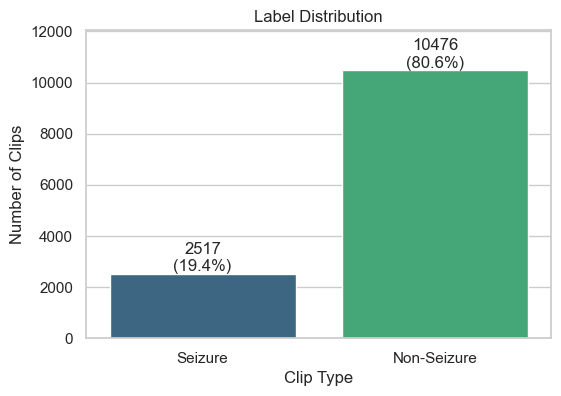

In [119]:
# Create a DataFrame for the label distribution plot
label_df = pd.DataFrame({'label': dataset_tr.get_label_array()})
label_df['Clip Type'] = label_df['label'].map({0: 'Non-Seizure', 1: 'Seizure'})

# Plot the label distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=label_df, x='Clip Type', palette='viridis', hue='Clip Type', dodge=False)
plt.title('Label Distribution')
plt.xlabel('Clip Type')
plt.ylabel('Number of Clips')

# Add counts and percentages on top of bars
total_count = len(label_df)
for container in ax.containers:
    labels = [f'{int(v)}\n({(100 * v / total_count):.1f}%)' for v in container.datavalues]
    ax.bar_label(container, labels=labels)

plt.ylim(0, label_df['Clip Type'].value_counts().max() * 1.15) # Adjust y-limit for text
plt.show()

There is a significant class imbalance, with seizure segments being much less frequent than non-seizure segments (~2500 records vs ~10500 records). To address this challenge, the following techniques can be employed:

- Use data splitting strategies that preserve the original class distribution (stratified splitting)
- Implementing oversampling methods to increase the representation of the minority class (seizure segments)

### Patients vs sessions vs segments: understanding magnitude of the data

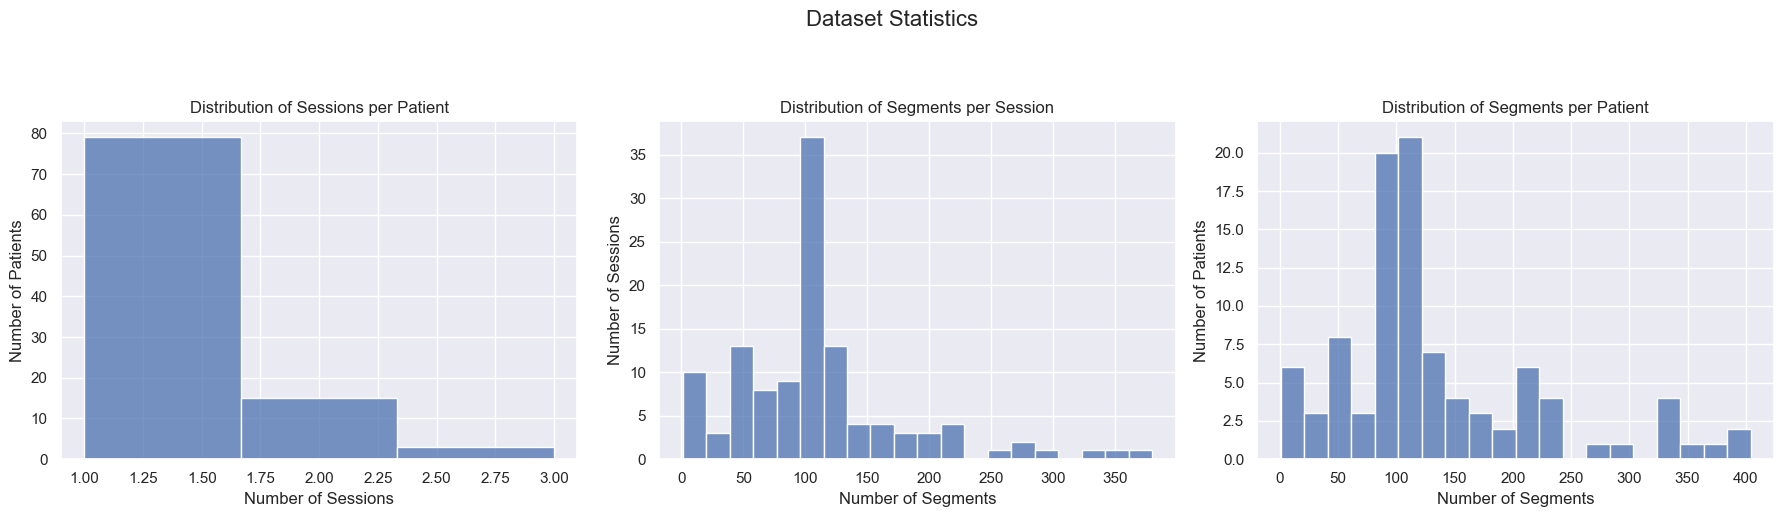

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Dataset Statistics', fontsize=16, y=1.03) # Add a main title

# 1. Distribution of Number of Sessions per Patient
try:
    # for each patient, how many unique values exist for each of the other index levels/columns
    patient_sessions_df = dataset_tr.clips_df.groupby(level="patient").nunique()
    num_sessions_per_patient = dataset_tr.clips_df.reset_index().groupby('patient')['session'].nunique()
    sns.histplot(data=num_sessions_per_patient, ax=axes[0], kde=False, bins=max(1, num_sessions_per_patient.max()))
    axes[0].set_title('Distribution of Sessions per Patient')
    axes[0].set_xlabel('Number of Sessions')
    axes[0].set_ylabel('Number of Patients')
except Exception as e:
    axes[0].set_title('Error: Sessions per Patient')
    axes[0].text(0.5, 0.5, f"Could not plot:\n{e}", ha='center', va='center', wrap=True)
    print(f"Error plotting 'Sessions per Patient': {e}")


# 2. Distribution of segments per session
try:
    segments_per_session = dataset_tr.clips_df.groupby(level=['patient', 'session']).size()
    sns.histplot(data=segments_per_session, ax=axes[1], kde=False, bins=20) # Adjust bins as needed
    axes[1].set_title('Distribution of Segments per Session')
    axes[1].set_xlabel('Number of Segments')
    axes[1].set_ylabel('Number of Sessions')
except Exception as e:
    axes[1].set_title('Error: Segments per Session')
    axes[1].text(0.5, 0.5, f"Could not plot:\n{e}", ha='center', va='center', wrap=True)
    print(f"Error plotting 'Segments per Session': {e}")


# 3. Distribution of Segments per patient
try:
    segments_per_patient = dataset_tr.clips_df.groupby(level='patient').size()
    sns.histplot(data=segments_per_patient, ax=axes[2], kde=False, bins=20)
    axes[2].set_title('Distribution of Segments per Patient')
    axes[2].set_xlabel('Number of Segments')
    axes[2].set_ylabel('Number of Patients')
except Exception as e:
    axes[2].set_title('Error: Segments per Patient')
    axes[2].text(0.5, 0.5, f"Could not plot:\n{e}", ha='center', va='center', wrap=True)
    print(f"Error plotting 'Segments per Patient': {e}")


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Patients vs seizures: understanding distribution of samples

In [121]:
%aimport util.stats
from util.stats import calculate_seizure_event_durations

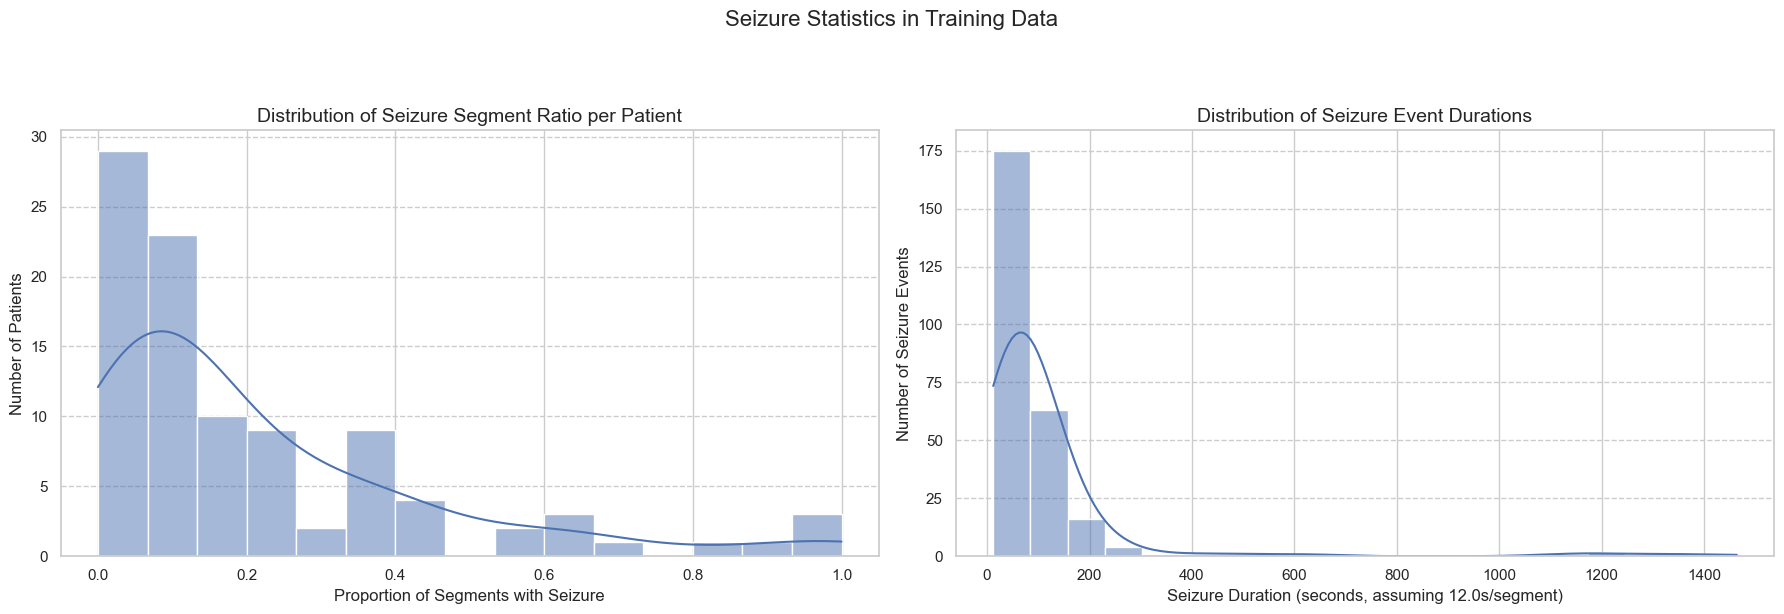

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6)) # Adjusted figsize slightly for better aspect
fig.suptitle('Seizure Statistics in Training Data', fontsize=16, y=1.02)

# 1. Seizure ratio per patient
try:
    seizure_ratio_per_patient = dataset_tr.clips_df.groupby("patient")["label"].mean()
    sns.histplot(seizure_ratio_per_patient, ax=axes[0], kde=True, bins=15)
    axes[0].set_title("Distribution of Seizure Segment Ratio per Patient", fontsize=14)
    axes[0].set_xlabel("Proportion of Segments with Seizure", fontsize=12)
    axes[0].set_ylabel("Number of Patients", fontsize=12)
    axes[0].grid(axis='y', linestyle='--')
except Exception as e:
    axes[0].set_title("Seizure Ratio per Patient", fontsize=14)
    axes[0].text(0.5, 0.5, f"Could not plot:\n{e}", ha='center', va='center', wrap=True)
    print(f"Error during seizure ratio plot: {e}")

# 2. Seizure event durations (Plot index was 1, matching original request for 2 plots)
try:
    # Calculate durations using the optimized function
    # This assumes dataset_tr.clips_df is sorted chronologically for consecutive segment checks
    seizure_durations_in_seconds = calculate_seizure_event_durations(
        dataset_tr.clips_df, 
        segment_duration_seconds=clip_length_seconds
    )
    sns.histplot(seizure_durations_in_seconds, ax=axes[1], kde=True, bins=20)
    axes[1].set_title("Distribution of Seizure Event Durations", fontsize=14)
    axes[1].set_xlabel(f"Seizure Duration (seconds, assuming {clip_length_seconds}s/segment)", fontsize=12)
    axes[1].set_ylabel("Number of Seizure Events", fontsize=12)
    axes[1].grid(axis='y', linestyle='--')
except Exception as e:
    axes[1].set_title("Seizure Event Durations", fontsize=14)
    axes[1].text(0.5, 0.5, f"Could not plot:\n{e}", ha='center', va='center', wrap=True)
    print(f"Error during seizure duration plot: {e}")


plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout for suptitle
plt.show()

### Seizure vs Non-Seizure Clips after filtering: per-channel signal overview

NameError: name 'sampling_rate' is not defined

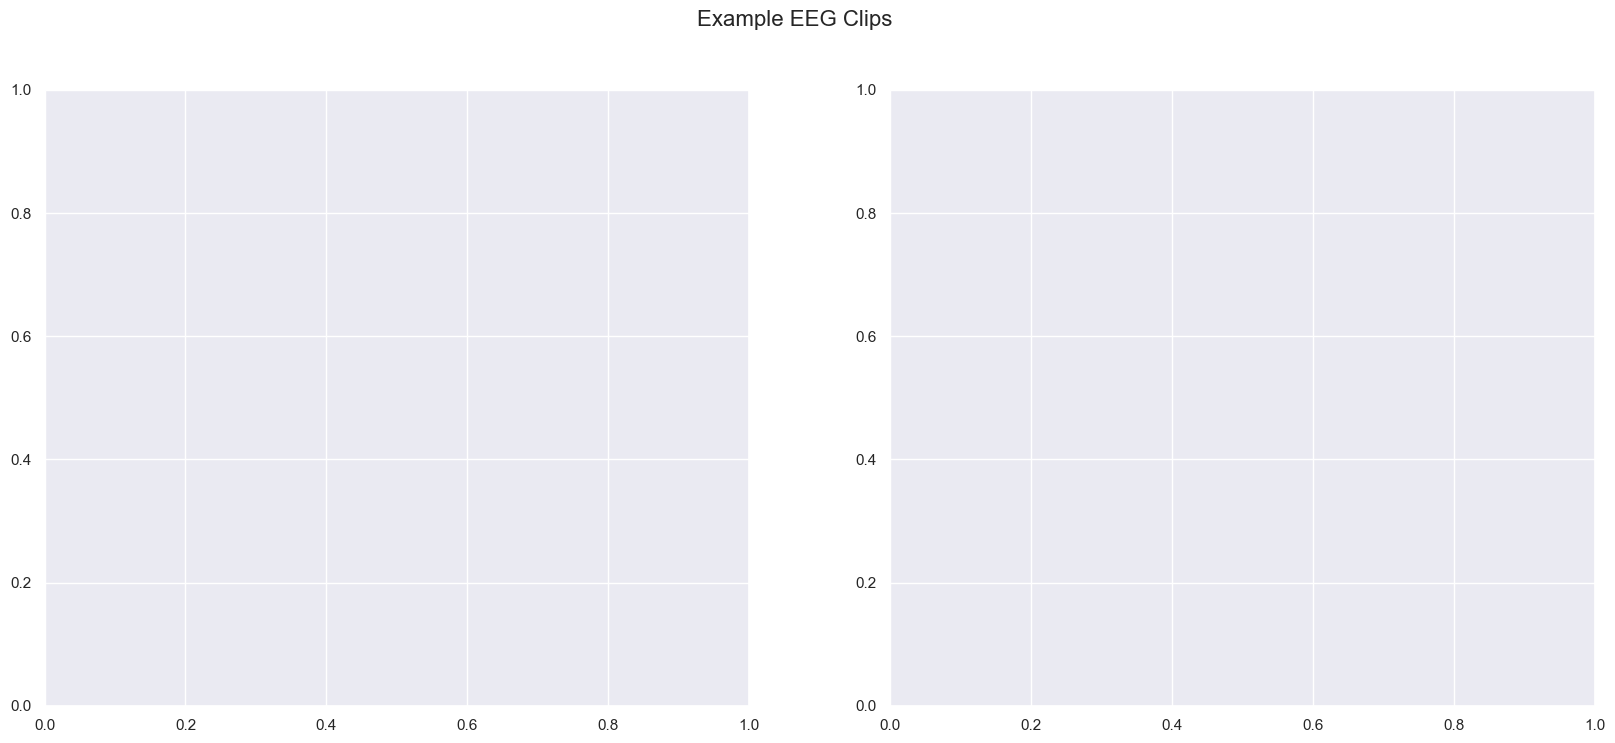

In [7]:
%aimport util.plot
from util.plot import plot_eeg_clip

MAX_ITERATION_LIMIT=1000
seizure_example = None
non_seizure_example = None

# skip first entry
for i, data_item in enumerate(dataset_tr[1:]):
    # Assuming dataset_tr yields (signal_array, label)
    if not (isinstance(data_item, (tuple, list)) and len(data_item) == 2):
        print(f"Warning: Item {i} from dataset_tr is not a (signal, label) tuple. Skipping.")
        continue
    
    x, y = data_item
    
    # If y is a tensor, get its item
    if hasattr(y, 'item'):
        y_val = y.item()
    else:
        y_val = y

    if isinstance(x, np.ndarray) and x.ndim == 2:
        if y_val == 1 and seizure_example is None:
            seizure_example = x
        elif y_val == 0 and non_seizure_example is None:
            non_seizure_example = x
    else:
        if not (seizure_example is not None and non_seizure_example is not None):
            print(f"Warning: Item {i} signal data is not a 2D numpy array. Shape: {x.shape if hasattr(x, 'shape') else type(x)}. Skipping.")

    # Stop if both examples are found
    if seizure_example is not None and non_seizure_example is not None:
        break
    # add limit to search
    if i > MAX_ITERATION_LIMIT: 
        print("Warning: Reached iteration limit before finding both example types.")
        break

fig, axes = plt.subplots(1, 2, figsize=(20, 8)) # 1 row, 2 columns
fig.suptitle("Example EEG Clips", fontsize=16, y=0.98)

# Plot non-seizure example on the first subplot (axes[0])
if non_seizure_example is not None:
    plot_eeg_clip(non_seizure_example, "Non-Seizure Example", 
                    sampling_rate, channel_names, offset_factor=10, ax=axes[0])
else:
    print("\n❌ Could not find a non-seizure example clip to plot.")
    axes[0].text(0.5, 0.5, "Non-seizure example not found", ha='center', va='center', fontsize=12)
    axes[0].set_title("Non-Seizure Example")

# Plot seizure example on the second subplot (axes[1])
if seizure_example is not None:
    plot_eeg_clip(seizure_example, "Seizure Example", 
                    sampling_rate, channel_names, offset_factor=10, ax=axes[1])
else:
    print("\n❌ Could not find a seizure example clip to plot.")
    axes[1].text(0.5, 0.5, "Seizure example not found", ha='center', va='center', fontsize=12)
    axes[1].set_title("Seizure Example")

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()

### Seizure vs Non-Seizure Clips: Power Spectral Density

The [*Power Spectral Density* (PSD)](https://en.wikipedia.org/wiki/Spectral_density) describes how the power of a signal (like EEG, often treated as a stationary random process over short intervals) is distributed across different frequencies. It's suitable for ongoing signals where total energy might be infinite, but average power is finite.

The *Power Spectral Density*, $S_{xx}(f)$, is fundamentally related to the signal's autocorrelation function, $R_{xx}(\tau)$, via the [Wiener-Khinchin theorem](https://en.wikipedia.org/wiki/Wiener%E2%80%93Khinchin_theorem), which states that the PSD is the Fourier transform ($\mathcal{F}$) of the autocorrelation function:

$$
S_{xx}(f) = \mathcal{F}\{\mathbf{R}_{xx}(\tau)\}
$$

In practice, the PSD function $S_{xx}(f)$ can be estimated from finite signal segments using techniques like [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method), which averages modified periodograms from overlapping windowed portions of the signal.

Suggested resources:

- <https://ethz.ch/content/dam/ethz/special-interest/baug/ibk/structural-mechanics-dam/education/identmeth/2020/welch.pdf>
- <https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html>

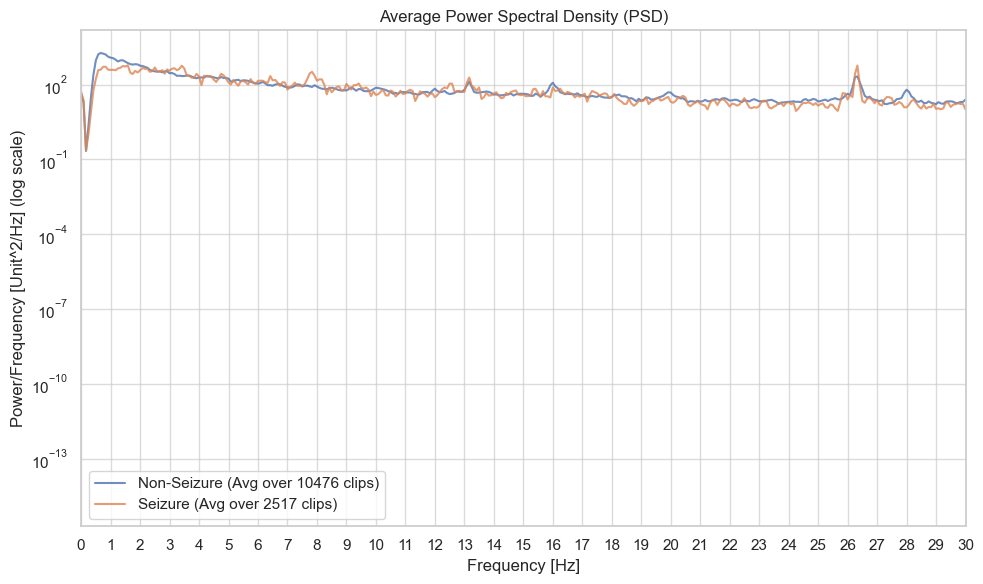

PSD calculation complete for 2517 seizure and 10476 non-seizure clips (out of 12993 processed).


In [35]:
from scipy.signal import welch

# local variables to store partial results
psd_seizure = []
psd_non_seizure = []
count_seizure = 0
count_non_seizure = 0

# NOTE: limit for number of clips to process.
# Increasing this, means more precision, but also more memory + computation time
limit = 10e4 # default limit: 100k clips
processed_count = 0

# cycle through dataset
freqs = None 
for x, y in dataset_tr:
    # check if we reached the limit of clips to process
    if processed_count >= limit:
        print(f"Reached calculation limit of {limit} clips for PSD.")
        break
    processed_count += 1

    # Ensure that clip is well-formed
    if not isinstance(x, np.ndarray) or x.ndim != 2 or x.shape[0] < 2: # Need at least 2 points for welch
            print(f"Warning: Skipping clip {processed_count} due to invalid data shape {x.shape if isinstance(x, np.ndarray) else type(x)}")
            continue

    # unpack current clip data
    actual_time_points, actual_num_channels = x.shape

    # --- Calculate PSD using Welch's method ---
    # Use nperseg=sampling_rate = 1-second windows (250Hz => 250 points)
    # Since each segment is 12 seconds, we can use directly the entire clip!
    # NOTE: in order to avoid problem if we miss some data, we can use the minimum between the clip length and the actual time points
    nperseg_val = min(sampling_rate * clip_length_seconds, actual_time_points)
    if nperseg_val < 2: # Welch requires nperseg >= 2
            print(f"Warning: Skipping clip {processed_count} due to insufficient length ({actual_time_points}) for PSD calculation.")
            continue
    try:
        # Calculate PSD for each channel (axis=0)
        f, psd_chans = welch(x, fs=sampling_rate, axis=0, nperseg=nperseg_val)
        if freqs is None: # Store frequencies from the first successful calculation
            freqs = f

        # Average PSD across channels for this clip
        psd_clip_avg = psd_chans.mean(axis=1)

        # store the PSD for the current clip in the appropriate list
        if y == 1:
            psd_seizure.append(psd_clip_avg)
            count_seizure += 1
        else:
            psd_non_seizure.append(psd_clip_avg)
            count_non_seizure += 1
    except ValueError as e:
            # skip if calculation gives an error
            print(f"Warning: Error calculating PSD for clip {processed_count}: {e}")
            continue

# --- Compute average PSD for each class (seizure / non-seizure) ---
avg_psd_seizure = np.mean(psd_seizure, axis=0) if count_seizure > 0 else None
avg_psd_non_seizure = np.mean(psd_non_seizure, axis=0) if count_non_seizure > 0 else None

# --- Plotting PSD ---
if freqs is not None:
    plt.figure(figsize=(10, 6))
    plot_successful = False
    if avg_psd_non_seizure is not None:
        # Ensure avg_psd has same length as freqs
        if len(avg_psd_non_seizure) == len(freqs):
             plt.semilogy(freqs, avg_psd_non_seizure, label=f'Non-Seizure (Avg over {count_non_seizure} clips)', alpha=0.8)
             plot_successful = True
        else:
             print(f"Warning: Mismatch between freqs ({len(freqs)}) and non-seizure PSD ({len(avg_psd_non_seizure)}) lengths.")

    if avg_psd_seizure is not None:
        # Ensure avg_psd has same length as freqs
        if len(avg_psd_seizure) == len(freqs):
            plt.semilogy(freqs, avg_psd_seizure, label=f'Seizure (Avg over {count_seizure} clips)', alpha=0.8)
            plot_successful = True
        else:
             print(f"Warning: Mismatch between freqs ({len(freqs)}) and seizure PSD ({len(avg_psd_seizure)}) lengths.")

    if plot_successful:
        plt.title('Average Power Spectral Density (PSD)')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Power/Frequency [Unit^2/Hz] (log scale)')
        plt.xlim(0.5, 30) # Limit to only the first 30 Hz (the other frequencies have been filtered out!)
        plt.xticks(np.arange(0, 31, 1))
        plt.legend()  # check if we reached the limit of clips to process
        # Customize grid from seaborn theme if needed
        plt.grid(True, which='major', axis='y', linestyle='-', alpha=0.7)
        plt.grid(True, which='minor', axis='y', linestyle=':', alpha=0.5)
        plt.grid(True, axis='x', linestyle='-', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("No PSD data was successfully prepared for plotting.")
elif processed_count > 0:
     print("Could not determine frequencies from the processed clips.")
else:
     print("No clips were processed for PSD.")


# Final status summary
if count_seizure == 0 and count_non_seizure == 0:
    print("No clips successfully processed for PSD.")
elif count_seizure == 0:
    print(f"Processed {count_non_seizure} non-seizure clips for PSD, but no seizure clips found/processed.")
elif count_non_seizure == 0:
    print(f"Processed {count_seizure} seizure clips for PSD, but no non-seizure clips found/processed.")
else:
    print(f"PSD calculation complete for {count_seizure} seizure and {count_non_seizure} non-seizure clips (out of {processed_count} processed).")


From the plot above is possible to see that the PSD shapes are similar, with power decreasing as frequency increases. However, there's a clear distinction in the $1−7$ Hz range (delta and theta bands), where the non-seizure class shows significantly higher average power compared to the seizure class. Above approximately $7$ Hz, the power levels for both classes become nearly identical. 

This indicates that increased low-frequency power is the primary differentiator observed in this PSD analysis.

### Seizure vs Non-Seizure Clips: Channel-wise variance

In the previous plot we examined the overall signal power overtime, and identified an important feature to distinguish between the two classes.

In this new analysis we focus on the channel-wise signal variance across seizure - non-seizure clips. This allows us to understand whether certain sensors give interesting results.

⏳ Calculating channel variances for up to 10000 clips...
   Processed 1000/10000 clips...
   Processed 2000/10000 clips...
   Processed 3000/10000 clips...
   Processed 4000/10000 clips...
   Processed 5000/10000 clips...
   Processed 6000/10000 clips...
   Processed 7000/10000 clips...
   Processed 8000/10000 clips...
   Processed 9000/10000 clips...
   Processed 10000/10000 clips...
✔️ Reached calculation limit of 10000 clips for variance.
✔️ Finished calculating variances for 10000 clips.
📊 Plotting channel variance distributions...


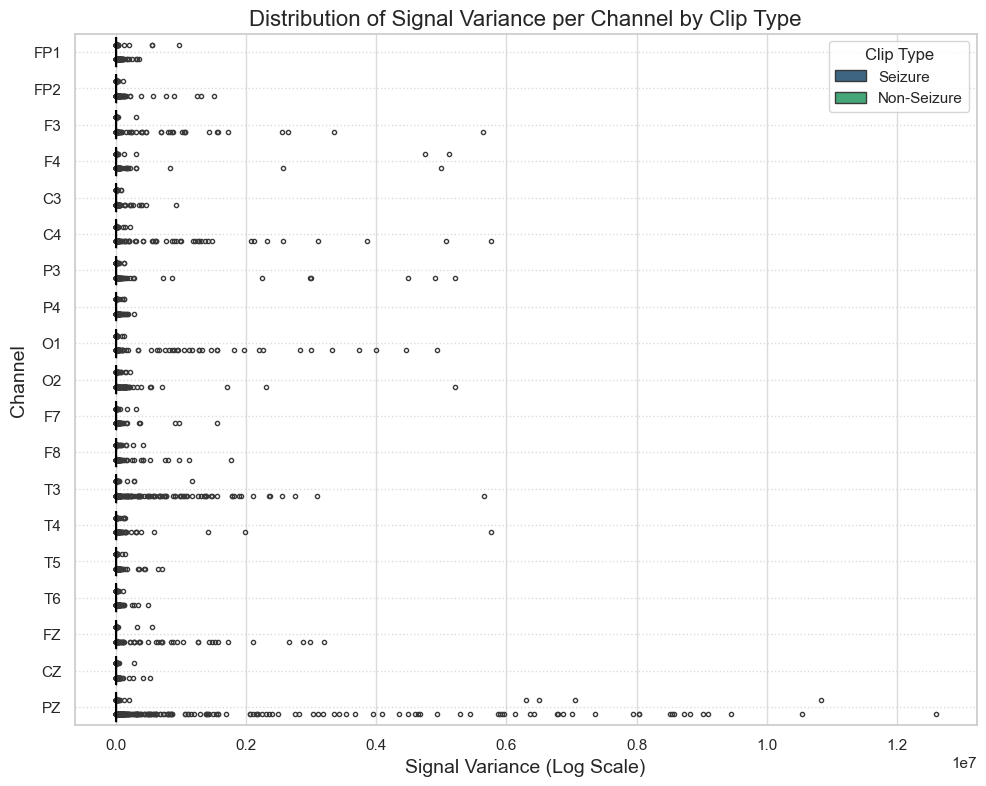

In [36]:
# --- Calculation of Channel Variances ---
channel_variances_data = [] # Renamed to avoid conflict if cell is re-run
limit = 10000 # Reduced limit for faster demo, adjust as needed (10e4 is 100,000)

print(f"⏳ Calculating channel variances for up to {limit} clips...")
processed_count = 0
for x_sample, y_label in dataset_tr: # More descriptive variable names
    if processed_count >= limit:
        print(f"✔️ Reached calculation limit of {limit} clips for variance.")
        break
    
    # Handle labels that might be PyTorch tensors
    if hasattr(y_label, 'item'):
        y_val = y_label.item()
    else:
        y_val = y_label

    if isinstance(x_sample, np.ndarray) and x_sample.ndim == 2:
        # x_sample shape is expected to be (time_points, channels)
        # Calculate variance along the time axis (axis=0) for each channel
        variances_per_channel = np.var(x_sample, axis=0)
        
        num_channels_in_sample = x_sample.shape[1]

        for i, var_val in enumerate(variances_per_channel):
            # Ensure channel_names list is long enough, provide fallback
            ch_name = channel_names[i] if i < num_channels else f'UnknownCh{i+1}'
            channel_variances_data.append({
                'variance': var_val,
                'label': y_val, # Use the processed scalar label
                'channel_index': i,
                'channel_name': ch_name
            })
    else:
        print(f"Warning: Skipping item {processed_count} due to unexpected data format. X type: {type(x_sample)}, X ndim: {x_sample.ndim if hasattr(x_sample, 'ndim') else 'N/A'}")
    processed_count += 1
    if processed_count % (limit // 10 if limit >=10 else 1) == 0:
        print(f"   Processed {processed_count}/{limit} clips...")

print(f"✔️ Finished calculating variances for {processed_count} clips.")

# --- Create DataFrame for Plotting ---
variance_df = pd.DataFrame(channel_variances_data)
variance_df['Clip Type'] = variance_df['label'].map({0: 'Non-Seizure', 1: 'Seizure'})

# Ensure channel_name is categorical and ordered if CHANNEL_NAMES has a defined order
if channel_names and all(name in variance_df['channel_name'].unique() for name in channel_names):
    variance_df['channel_name'] = pd.Categorical(variance_df['channel_name'], categories=channel_names, ordered=True)
    variance_df.sort_values('channel_name', inplace=True)

# --- Plotting Channel Variance Box Plots ---
print("📊 Plotting channel variance distributions...")

# Adjust figsize: more height if many channels
num_unique_channels = variance_df['channel_name'].nunique()
fig_height = max(8, num_unique_channels * 0.4)
plt.figure(figsize=(10, fig_height)) 

sns.set_theme(style="whitegrid") # Apply seaborn theme
sns.boxplot(
    data=variance_df,
    x='variance',
    y='channel_name',
    hue='Clip Type',
    orient='h',
    palette='viridis', # Example palette: "Set2", "Paired", "husl"
    showfliers=True,  # Changed to True: Show outliers, especially useful with log scale
    fliersize=3,      # Adjust flier size if needed
    linewidth=1.0,    # Box line width
    whiskerprops=dict(linewidth=1.0), # Whisker line width
    capprops=dict(linewidth=1.0),     # Cap line width
    medianprops=dict(color="black", linewidth=1.5) # Make median line distinct
)
plt.title('Distribution of Signal Variance per Channel by Clip Type', fontsize=16)
plt.xlabel('Signal Variance (Log Scale)', fontsize=14) # Unit can be added if known, e.g., (µV² log scale)
plt.ylabel('Channel', fontsize=14)

# Apply log scale to x-axis
if variance_df['variance'].min() <= 0:
    print("Warning: Non-positive variance values found. Log scale might behave unexpectedly or error.")
else:
    plt.xscale('log')

plt.legend(title='Clip Type', loc='best') # 'best' might find a better spot

# Customize grid
plt.grid(True, which='major', axis='x', linestyle='-', alpha=0.7)
plt.grid(True, which='minor', axis='x', linestyle=':', alpha=0.4) # For log scale
plt.grid(True, axis='y', linestyle=':', alpha=0.7)

plt.tight_layout(pad=1.0)
plt.show()

Observing the boxplots which display the distribution of signal variance for each channel, separated by class, a noticeable pattern occurs for certain channels. 

Specifically, for the non-seizure clips associated with channels $F3$, $F4$, $C3$, $C4$, $T3$, $FZ$, and $CZ$, the boxplots often show a wider spread extending towards lower variance values compared to the seizure clips. This is indicated by longer lower whiskers or the presence of outliers on the left side of the distribution (on the log scale). 

This suggests that non-seizure activity within these particular channels might include periods of lower signal variance than what is typically observed during seizure activity in this dataset.

### Seizure vs Non-Seizure Clips: Channel Correlation Matrix

Having previously identified channels that appear promising for distinguishing between seizure and non-seizure activity based on our analysis, this next step aims to confirm this hypothesis. We will now seek to validate which of the 19 channels are indeed the most meaningful discriminators between these two brain states.

⏳ Calculating correlation matrices for up to 100000.0 clips...
   Processed 10000/100000.0 clips for correlation...
✔️ Finished calculating correlations for 12993 clips.
   Found 2517 seizure clips with valid correlations.
   Found 10461 non-seizure clips with valid correlations.


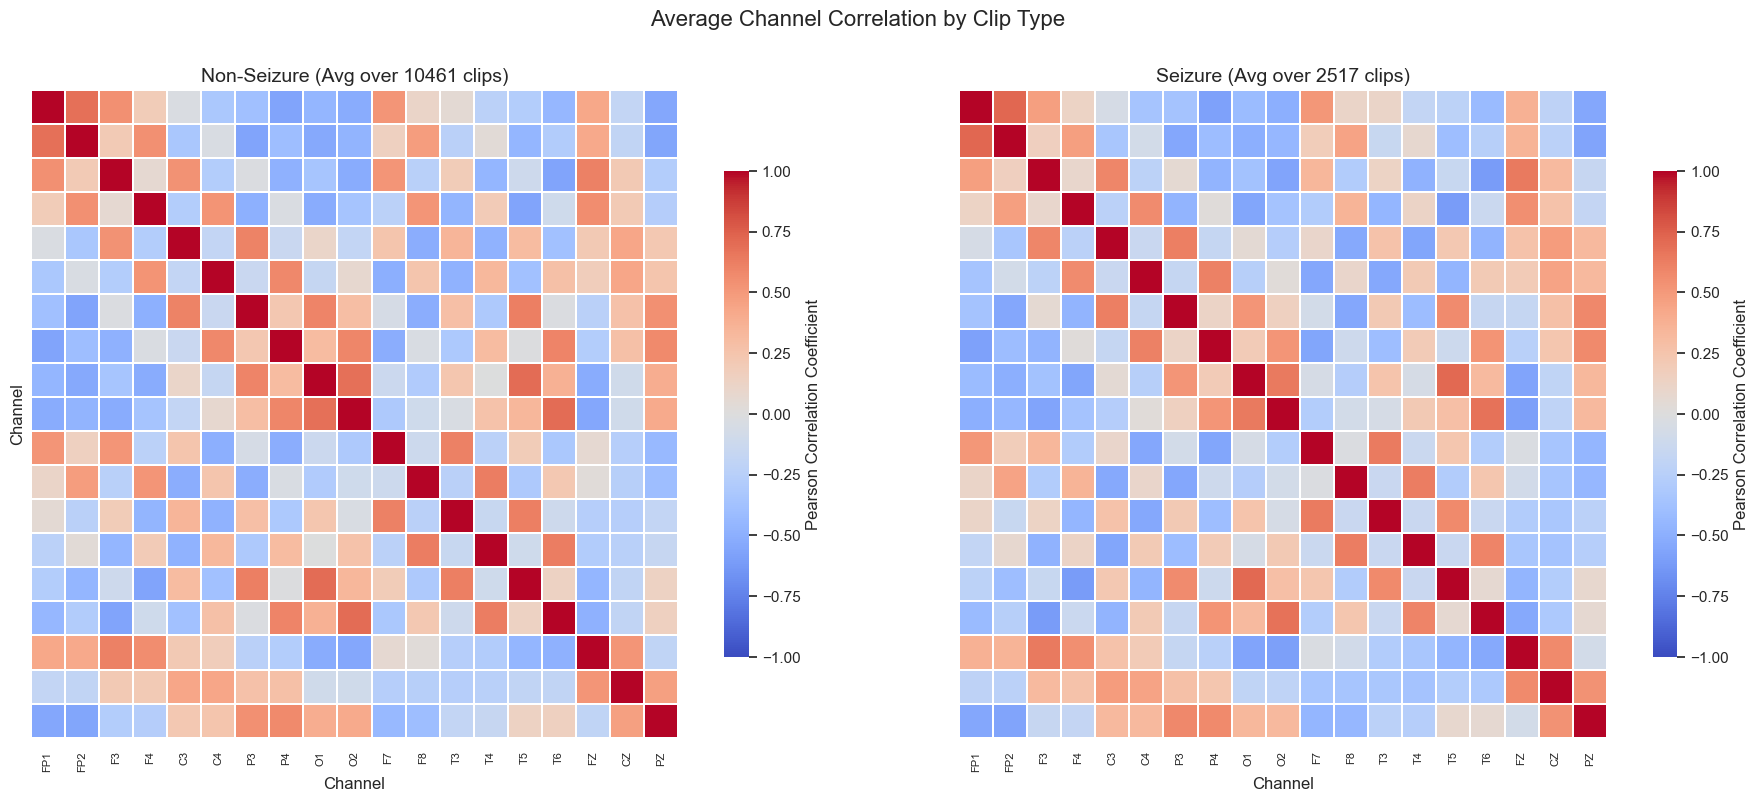

In [37]:
# --- Store correlation matrices for each class ---
corr_matrices_seizure = []
corr_matrices_non_seizure = []
limit = 10e4

print(f"⏳ Calculating correlation matrices for up to {limit} clips...")
processed_count = 0
for x_sample, y_label in dataset_tr:
    if processed_count >= limit:
        print(f"✔️ Reached calculation limit of {limit} clips for correlation.")
        break
    
    # Handle labels that might be PyTorch tensors
    if hasattr(y_label, 'item'):
        y_val = y_label.item()
    else:
        y_val = y_label

    # Ensure x_sample is a 2D numpy array with sufficient dimensions for correlation
    if isinstance(x_sample, np.ndarray) and x_sample.ndim == 2 and x_sample.shape[0] > 1 and x_sample.shape[1] > 1:
        num_channels_in_sample = x_sample.shape[1]
        current_channel_names = channel_names[:num_channels_in_sample] if num_channels >= num_channels_in_sample else [f'Ch{i+1}' for i in range(num_channels_in_sample)]

        # Create a DataFrame for easy correlation calculation
        clip_df = pd.DataFrame(x_sample, columns=current_channel_names)
        
        # Calculate pairwise correlation between channels
        try:
            corr_matrix = clip_df.corr()
            # Store based on label (only if calculation is successful and no NaNs)
            if not corr_matrix.isnull().values.any(): # Check for NaNs
                if y_val == 1:
                    corr_matrices_seizure.append(corr_matrix.values) # Store as numpy array
                else:
                    corr_matrices_non_seizure.append(corr_matrix.values) # Store as numpy array
            else:
                # This can happen if a channel has zero variance in the clip
                # print(f"Warning: NaN found in correlation matrix for clip {processed_count}. Skipping.")
                pass
        except Exception as e:
            # print(f"Warning: Could not compute correlation for clip {processed_count}. Error: {e}. Skipping.")
            pass
    else:
        # print(f"Warning: Skipping item {processed_count} due to unexpected data format or insufficient dimensions.")
        pass
        
    processed_count += 1
    if processed_count % (limit // 10 if limit >=10 else 1) == 0: # Progress update
         print(f"   Processed {processed_count}/{limit} clips for correlation...")

print(f"✔️ Finished calculating correlations for {processed_count} clips.")
print(f"   Found {len(corr_matrices_seizure)} seizure clips with valid correlations.")
print(f"   Found {len(corr_matrices_non_seizure)} non-seizure clips with valid correlations.")

# --- Calculate the average correlation matrix for each class ---
avg_corr_seizure = None
avg_corr_non_seizure = None
num_channels_for_plot = 0 # Number of channels for axis labeling

if len(corr_matrices_seizure) > 0: # Check length instead of just if list exists
    avg_corr_seizure = np.mean(np.array(corr_matrices_seizure), axis=0) # Ensure it's an array for np.mean
    if avg_corr_seizure is not None: num_channels_for_plot = avg_corr_seizure.shape[0]
if len(corr_matrices_non_seizure) > 0:
    avg_corr_non_seizure = np.mean(np.array(corr_matrices_non_seizure), axis=0)
    if avg_corr_non_seizure is not None and num_channels_for_plot == 0: 
        num_channels_for_plot = avg_corr_non_seizure.shape[0]

# Determine effective channel names for plotting based on actual matrix size
effective_plot_channel_names = channel_names[:num_channels_for_plot] if num_channels_for_plot > 0 and num_channels >= num_channels_for_plot else [f'Ch{i+1}' for i in range(num_channels_for_plot)]


# --- Plotting Average Correlation Heatmaps ---
if avg_corr_non_seizure is not None or avg_corr_seizure is not None:
    fig, axes = plt.subplots(1, 2, figsize=(19, 8), sharey=True) # Slightly wider
    fig.suptitle('Average Channel Correlation by Clip Type', fontsize=16, y=0.98)

    # Determine common color scale range
    vmin_plot, vmax_plot = -1.0, 1.0 # Default for correlation
    
    valid_avg_corrs_list = []
    if avg_corr_non_seizure is not None and np.any(np.isfinite(avg_corr_non_seizure)):
        valid_avg_corrs_list.append(avg_corr_non_seizure)
    if avg_corr_seizure is not None and np.any(np.isfinite(avg_corr_seizure)):
        valid_avg_corrs_list.append(avg_corr_seizure)

    if valid_avg_corrs_list:
        all_finite_vals = np.concatenate([m[np.isfinite(m)].flatten() for m in valid_avg_corrs_list])
        if all_finite_vals.size > 0:
            current_vmin = np.min(all_finite_vals)
            current_vmax = np.max(all_finite_vals)
            if current_vmin < 0 and current_vmax > 0: # If data spans positive and negative
                abs_max = max(abs(current_vmin), abs(current_vmax))
                vmin_plot = -abs_max
                vmax_plot = abs_max

    common_heatmap_kwargs = dict(
        cmap='coolwarm',
        vmin=vmin_plot, vmax=vmax_plot,
        square=True,
        linewidths=.3, # Slightly thinner lines
        cbar_kws={"shrink": .75, "label": "Pearson Correlation Coefficient"}, # Adjusted shrink
        annot=False # Annotations can be very dense; consider True for small matrices
    )

    plot_successful = False
    # Plot Non-Seizure Heatmap
    current_ax_idx = 0
    if avg_corr_non_seizure is not None:
        sns.heatmap(
            avg_corr_non_seizure, ax=axes[current_ax_idx],
            xticklabels=effective_plot_channel_names,
            yticklabels=effective_plot_channel_names, # Y-labels on the first plot
            **common_heatmap_kwargs
        )
        axes[current_ax_idx].set_title(f'Non-Seizure (Avg over {len(corr_matrices_non_seizure)} clips)', fontsize=14)
        axes[current_ax_idx].set_xlabel('Channel', fontsize=12)
        axes[current_ax_idx].set_ylabel('Channel', fontsize=12)
        axes[current_ax_idx].tick_params(axis='x', rotation=90, labelsize=8)
        axes[current_ax_idx].tick_params(axis='y', rotation=0, labelsize=8)
        plot_successful = True
    else:
        axes[current_ax_idx].set_title('Non-Seizure (No data)', fontsize=14)
        axes[current_ax_idx].text(0.5,0.5, "No data", horizontalalignment='center', verticalalignment='center', transform=axes[current_ax_idx].transAxes)

    # Plot Seizure Heatmap
    current_ax_idx = 1
    if avg_corr_seizure is not None:
        sns.heatmap(
            avg_corr_seizure, ax=axes[current_ax_idx],
            xticklabels=effective_plot_channel_names,
            yticklabels=False, # No y-labels on the second plot due to sharey=True
            **common_heatmap_kwargs
        )
        axes[current_ax_idx].set_title(f'Seizure (Avg over {len(corr_matrices_seizure)} clips)', fontsize=14)
        axes[current_ax_idx].set_xlabel('Channel', fontsize=12)
        # axes[current_ax_idx].set_ylabel('Channel') # Not needed due to sharey=True
        axes[current_ax_idx].tick_params(axis='x', rotation=90, labelsize=8)
        plot_successful = True
    else:
        axes[current_ax_idx].set_title('Seizure (No data)', fontsize=14)
        axes[current_ax_idx].text(0.5,0.5, "No data", horizontalalignment='center', verticalalignment='center', transform=axes[current_ax_idx].transAxes)
    
    if plot_successful:
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect for suptitle
        plt.show()
    else: # If both plots failed (e.g. no data at all)
        plt.close(fig) # Close the empty figure
        print("Neither seizure nor non-seizure correlation data was available to plot.")
else:
    print("❌ No correlation data was successfully calculated to plot.")


To identify channel pairs whose correlation patterns differ significantly between seizure and non-seizure states, we can compute a **correlation difference matrix**. This matrix highlights the connections that change the most, potentially indicating relevance for distinguishing between the two classes.

The change in correlation, $c^{\text{change}}$, between any two channels $i$ and $j$ is calculated as the absolute difference between their average correlation coefficients in the seizure ($c_{ij}^{\text{seizure}}$) and non-seizure ($c_{ij}^{\text{non-seizure}}$) states:

$$
c_{ij}^{\text{change}} = |c_{ij}^{\text{seizure}} - c_{ij}^{\text{non-seizure}}|
$$

High values in this matrix correspond to channel pairs where the functional connectivity (as measured by linear correlation) undergoes the largest change between the two conditions.

✅ Calculating difference between average seizure and non-seizure correlation matrices.
📊 Plotting the difference correlation matrix...


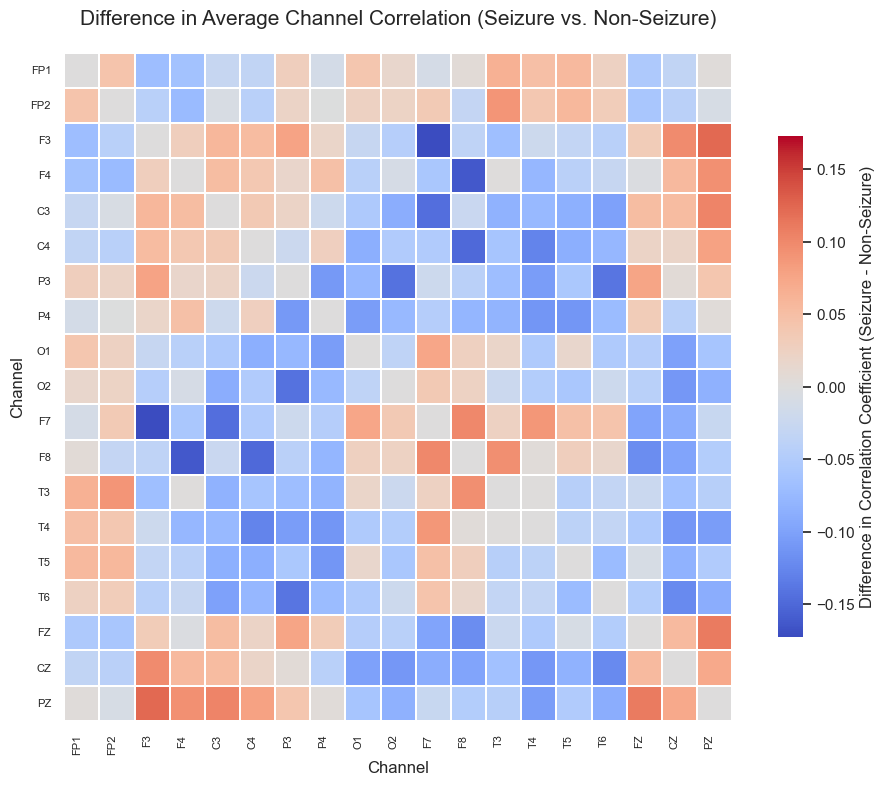

In [38]:
# --- Calculate the Difference Correlation Matrix ---
diff_corr_matrix = None
if avg_corr_seizure is not None and avg_corr_non_seizure is not None:
    if avg_corr_seizure.shape == avg_corr_non_seizure.shape:
        print("✅ Calculating difference between average seizure and non-seizure correlation matrices.")
        diff_corr_matrix = avg_corr_seizure - avg_corr_non_seizure
    else:
        print("❌ Error: Average correlation matrices (seizure and non-seizure) have different shapes. Cannot compute difference.")
        print(f"   Seizure shape: {avg_corr_seizure.shape}, Non-Seizure shape: {avg_corr_non_seizure.shape}")
elif avg_corr_seizure is None:
    print("❌ Error: Average seizure correlation matrix is not available. Cannot compute difference.")
elif avg_corr_non_seizure is None:
    print("❌ Error: Average non-seizure correlation matrix is not available. Cannot compute difference.")

# --- Plotting the Difference Correlation Heatmap ---
if diff_corr_matrix is not None and num_channels_for_plot > 0:
    print("📊 Plotting the difference correlation matrix...")
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 8)) # Adjust size as needed

    # Determine vmin and vmax for the difference matrix, centered at 0
    abs_max_diff = np.nanmax(np.abs(diff_corr_matrix)) # Max absolute difference
    vmin_diff = -abs_max_diff
    vmax_diff = abs_max_diff
    
    # If abs_max_diff is very close to zero, set a small default range to avoid issues with heatmap
    if np.isclose(abs_max_diff, 0):
        print("Warning: Maximum absolute difference is close to zero. Setting a default range for colormap.")
        vmin_diff, vmax_diff = -0.1, 0.1

    sns.heatmap(
        diff_corr_matrix,
        cmap='coolwarm', # Diverging colormap, good for differences around zero
        vmin=vmin_diff,
        vmax=vmax_diff,
        square=True,
        linewidths=.3,
        annot=False, # Annotations can be too dense; set to True or a matrix of strings for select values
        # annot_kws={"size": 7}, # if annot=True
        cbar_kws={"shrink": .75, "label": "Difference in Correlation Coefficient (Seizure - Non-Seizure)"},
        xticklabels=effective_plot_channel_names, # Use the channel names from previous step
        yticklabels=effective_plot_channel_names
    )

    plt.title('Difference in Average Channel Correlation (Seizure vs. Non-Seizure)', fontsize=15, y=1.03)
    plt.xlabel('Channel', fontsize=12)
    plt.ylabel('Channel', fontsize=12)
    plt.xticks(rotation=90, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    
    plt.tight_layout()
    plt.show()
else:
    if diff_corr_matrix is None:
        print("❌ No difference correlation matrix was calculated to plot.")
    elif num_channels_for_plot == 0:
        print("❌ Number of channels for plotting is zero. Cannot create heatmap.")


The absolute difference correlation matrix helps identify **pairs of channels** whose functional connectivity (measured by linear correlation) significantly changes between seizure and non-seizure states. By selecting the top $K$ pairs with the highest absolute difference values, we are essentially performing a feature selection strategy that prioritizes these **most altered pairwise interactions**.

In order to compute the **importance score** for individual channels based on this pairwise information, we use the sum of absolute differences across all other channels it is paired with. This score, $S_i$, for a channel $i$ reflects its total involvement in correlation changes:

$$
S_i = \sum_{j \neq i} |c_{ij}^{\text{seizure}} - c_{ij}^{\text{non-seizure}}| = \sum_{j \neq i} |c_{ij}^{\text{change}}|
$$

The top $K$ individual channels are then selected based on descending order of this score.

### Channel selection: identifying most important channels

In [39]:
from typing import Optional

def get_top_k_sensors_from_diff_corr(
    diff_corr_matrix: np.ndarray,
    channel_names: list[str],
    k: int,
    abs_values: bool = True
) -> Optional[list[tuple[str, float]]]:
    """
    Identifies the top K sensors that exhibit the largest changes in correlation
    based on the difference correlation matrix (seizure_avg_corr - non_seizure_avg_corr).

    The "score" for each sensor is the sum of the absolute values of its row/column
    in the difference correlation matrix (excluding the diagonal).

    Args:
        diff_corr_matrix (np.ndarray): The difference correlation matrix.
                                       Expected to be square.
        channel_names (List[str]): A list of channel names corresponding to the
                                   rows/columns of the diff_corr_matrix.
        k (int): The number of top sensors to return.
        abs_values (bool): If True (default), sums absolute differences. 
                           If False, sums raw differences (can be used to find sensors
                           that consistently increase or decrease correlations).

    Returns:
        Optional[List[Tuple[str, float]]]: A list of tuples, where each tuple
                                           contains (channel_name, score),
                                           sorted by score in descending order.
                                           Returns None if inputs are invalid.
    """
    # --- Input Validation ---
    if not isinstance(diff_corr_matrix, np.ndarray) or diff_corr_matrix.ndim != 2:
        print("Error: diff_corr_matrix must be a 2D NumPy array.")
        return None
    if diff_corr_matrix.shape[0] != diff_corr_matrix.shape[1]:
        print("Error: diff_corr_matrix must be a square matrix.")
        return None
    if not isinstance(channel_names, list) or len(channel_names) != diff_corr_matrix.shape[0]:
        print(f"Error: channel_names must be a list of strings with length "
              f"matching the dimensions of diff_corr_matrix ({diff_corr_matrix.shape[0]}).")
        return None
    if not isinstance(k, int) or k <= 0:
        print("Error: k must be a positive integer.")
        return None

    num_channels = diff_corr_matrix.shape[0]
    if k > num_channels:
        print(f"Warning: k ({k}) is greater than the number of available channels ({num_channels}). "
              f"Returning all channels sorted by score.")
        k = num_channels

    # --- Calculate Sensor Scores ---
    # Create a copy to avoid modifying the original matrix
    matrix_for_scoring = diff_corr_matrix.copy()
    
    # Set diagonal to 0 to exclude self-correlation changes (should be 0 anyway if original diagonals were 1)
    np.fill_diagonal(matrix_for_scoring, 0)

    if abs_values:
        # Sum of absolute changes in correlation for each sensor
        sensor_scores = np.sum(np.abs(matrix_for_scoring), axis=1) # Sum across rows
    else:
        # Sum of raw changes (positive changes increase score, negative changes decrease it)
        sensor_scores = np.sum(matrix_for_scoring, axis=1)


    # --- Pair scores with channel names ---
    scored_channels = []
    for i in range(num_channels):
        scored_channels.append((channel_names[i], sensor_scores[i]))

    # --- Sort channels by score in descending order ---
    # If abs_values is False, you might want to sort by absolute score for "top k"
    # or handle positive/negative scores separately depending on the goal.
    # Here, we sort by the score itself.
    if abs_values:
        scored_channels.sort(key=lambda item: item[1], reverse=True)
    else: # If summing raw differences, perhaps sort by absolute magnitude of the sum
        scored_channels.sort(key=lambda item: abs(item[1]), reverse=True)

    # --- Return top K sensors ---
    return scored_channels[:k]

In [40]:
k = 5
top_k_changing_sensors = get_top_k_sensors_from_diff_corr(
    diff_corr_matrix,
    effective_plot_channel_names,
    k
)

if top_k_changing_sensors:
    print(f"\nTop {k} sensors with the largest overall change in correlations:")
    for rank, (name, score) in enumerate(top_k_changing_sensors):
        print(f"  {rank+1}. {name} (Total Change Score: {score:.4f})")


Top 5 sensors with the largest overall change in correlations:
  1. CZ (Total Change Score: 1.2534)
  2. F7 (Total Change Score: 1.1731)
  3. PZ (Total Change Score: 1.1432)
  4. T4 (Total Change Score: 1.1397)
  5. F8 (Total Change Score: 1.0936)


## Data splitting and (possible) feature selection

In [41]:
from torch.utils.data import random_split

# ——— split training set into train & validation with pandas ———
print("⏳ Splitting into train/validation…")
split_start = time.time()
train_frac = 0.8
train_df   = clips_tr.sample(frac=train_frac)
val_df     = clips_tr.drop(train_df.index)
print(f"✔️ Split: {len(train_df)} train, {len(val_df)} val "
      f"(took {time.time()-split_start:.1f}s)")

# ——— rebuild training/validation datasets using the new split ———
print("⏳ Splitting dataset object into train/validation subsets…")
train_frac = 0.8
num_train_samples = int(len(dataset_tr) * train_frac)
num_val_samples = len(dataset_tr) - num_train_samples

dataset_tr, dataset_val = random_split(
    dataset_tr, [num_train_samples, num_val_samples]
)
print(f"✔️ Split complete: {len(dataset_tr)} train, {len(dataset_val)} val")

⏳ Splitting into train/validation…
✔️ Split: 10394 train, 2599 val (took 0.1s)
⏳ Splitting dataset object into train/validation subsets…
✔️ Split complete: 10394 train, 2599 val


In [42]:
# ——— create data loaders ———
print("⏳ Creating DataLoaders…")
dl_start = time.time()
common_loader_kwargs = dict(
    batch_size=128,
    num_workers=16,
    persistent_workers=True,
    pin_memory=True,
    prefetch_factor=8,
)

# NOTE: shuffle=True for training, False for validation and test in order to
#       maintain the order of the data (important for evaluation)
train_loader = DataLoader(dataset_tr, shuffle=True,  **common_loader_kwargs)
val_loader   = DataLoader(dataset_val, shuffle=False, **common_loader_kwargs)
test_loader  = DataLoader(dataset_te, shuffle=False, **common_loader_kwargs)
print(f"✔️ DataLoaders created (took {time.time()-dl_start:.1f}s):\n"
      f"   • train: {len(train_loader)} batches\n"
      f"   • val:   {len(val_loader)} batches\n"
      f"   • test:  {len(test_loader)} batches")

⏳ Creating DataLoaders…
✔️ DataLoaders created (took 0.1s):
   • train: 82 batches
   • val:   21 batches
   • test:  29 batches


/Users/lucadibello/Developer/NeuroGraphNet/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Traditional approaches (no additional features)

In [43]:
%aimport util.train
from util.train import train_model, evaluate_model

### 1. LSTM classifier (baseline)

In [25]:
%aimport layers.lstm
from layers.lstm import LSTM

# Create model and fit it
lstm_model = LSTM(input_dim=19, hidden_dim=64, num_layers=3, dropout=0.3)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    lstm_model = nn.DataParallel(lstm_model)   # splits batches across all GPUs
lstm_model = lstm_model.to(device)         # CPU or GPU

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

Attempting to load checkpoint from .checkpoints/lstm_best_model.pt...
Checkpoint found → model loaded, skipping training.


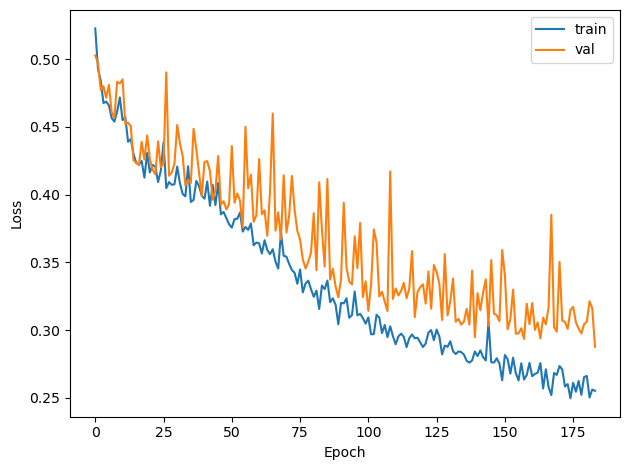

In [26]:
LSTM_SAVE_PATH = CHECKPOINT_ROOT / "lstm_best_model.pt"
LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "lstm_submission.csv"

# train model on training set (or load existing)
train_losses, val_losses = train_model(
        lstm_model, train_loader, val_loader,
        criterion, optimizer, device,
        save_path=LSTM_SAVE_PATH,
        num_epochs=300,
        patience=30,
        monitor="val_loss",
        scheduler=scheduler,
        overwrite=False,
    )

# plot losses if any
if train_losses:
    plt.figure()
    plt.plot(train_losses, label="train")
    plt.plot(val_losses,   label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [27]:
# evaluate model on test set and generate submission file
evaluate_model(
    lstm_model, test_loader, device,
    save_path=LSTM_SAVE_PATH,
    submission_path=LSTM_SUBMISSION_PATH,
)

Loading model for evaluation from: .checkpoints/lstm_best_model.pt


Evaluating: 100%|██████████| 29/29 [00:01<00:00, 15.20it/s]

Saved submission → .submissions/lstm_submission.csv



/home/ldibello/NeuroGraphNet/util/train.py:264: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  sub_df['id_sort_temp'] = pd.to_numeric(sub_df['id'], errors='ignore')


,id,label
0,pqejgcvm_s001_t000_0,1
1,pqejgcvm_s001_t000_1,0
10,pqejgcvm_s001_t000_10,1
11,pqejgcvm_s001_t000_11,1
12,pqejgcvm_s001_t000_12,1
...,...,...
3551,pqejgvej_s001_t000_95,0
3552,pqejgvej_s001_t000_96,0
3553,pqejgvej_s001_t000_97,0
3554,pqejgvej_s001_t000_98,0


### 2. Bidirectional LSTM with early stopping

In [28]:
from layers.lstm import BiLSTM

# Create model and fit it
bi_lstm_model = BiLSTM(input_dim=19, hidden_dim=64, num_layers=3, dropout=0.2)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    bi_lstm_model = nn.DataParallel(bi_lstm_model)   # splits batches across all GPUs
bi_lstm_model = bi_lstm_model.to(device)         # CPU or GPU

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(bi_lstm_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

Attempting to load checkpoint from .checkpoints/bi_lstm_best_model.pt...
Checkpoint found → model loaded, skipping training.


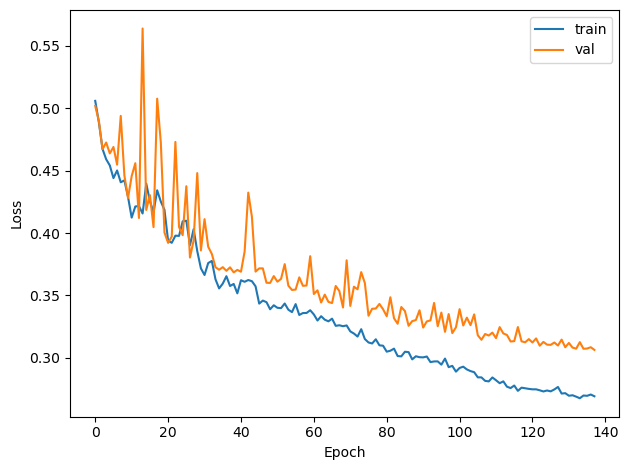

In [31]:
BI_LSTM_SAVE_PATH = CHECKPOINT_ROOT / "bi_lstm_best_model.pt"
BI_LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "bi_lstm_submission.csv"

# train model on training set (or load existing)
train_losses, val_losses = train_model(
        bi_lstm_model, train_loader, val_loader,
        criterion, optimizer, device,
        save_path=BI_LSTM_SAVE_PATH,
        num_epochs=300,
        patience=30,
        monitor="val_loss",
        scheduler=scheduler,
        overwrite=False,
    )

# plot losses if any
if train_losses:
    plt.figure()
    plt.plot(train_losses, label="train")
    plt.plot(val_losses,   label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [32]:
# evaluate model on test set and generate submission file
evaluate_model(
    bi_lstm_model, test_loader, device,
    save_path=BI_LSTM_SAVE_PATH,
    submission_path=BI_LSTM_SUBMISSION_PATH,
)

Loading model for evaluation from: .checkpoints/bi_lstm_best_model.pt


Evaluating: 100%|██████████| 29/29 [00:00<00:00, 133.95it/s]

Saved submission → .submissions/bi_lstm_submission.csv



/home/ldibello/NeuroGraphNet/util/train.py:264: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  sub_df['id_sort_temp'] = pd.to_numeric(sub_df['id'], errors='ignore')


,id,label
0,pqejgcvm_s001_t000_0,1
1,pqejgcvm_s001_t000_1,0
10,pqejgcvm_s001_t000_10,1
11,pqejgcvm_s001_t000_11,1
12,pqejgcvm_s001_t000_12,1
...,...,...
3551,pqejgvej_s001_t000_95,0
3552,pqejgvej_s001_t000_96,0
3553,pqejgvej_s001_t000_97,0
3554,pqejgvej_s001_t000_98,0


### 3. LSTM with Attention and early stopping

In [34]:
from layers.lstm import LSTMAttention

# Create model and fit it
attention_lstm_model = LSTMAttention(input_dim=19, hidden_dim=64, num_layers=3, dropout=0.2)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    attention_lstm_model = nn.DataParallel(attention_lstm_model)   # splits batches across all GPUs
attention_lstm_model = attention_lstm_model.to(device)         # CPU or GPU

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(
    attention_lstm_model.parameters(),
    lr=1e-3,
    weight_decay=1e-5
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min',
    patience=5,
    factor=0.5
)

Attempting to load checkpoint from .checkpoints/attention_lstm_best_model.pt...
Checkpoint found → model loaded, skipping training.


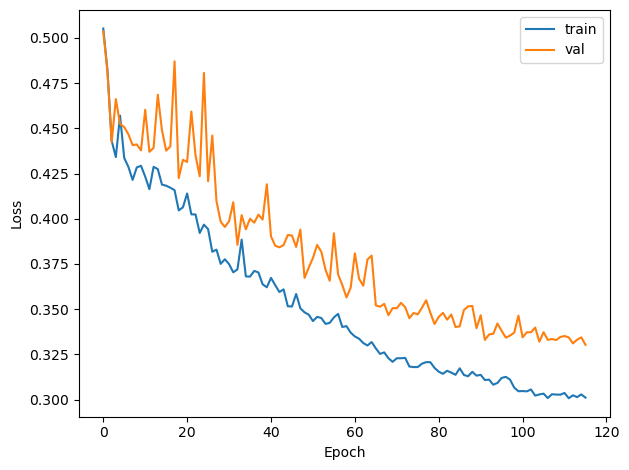

In [37]:
ATTENTION_LSTM_SAVE_PATH = CHECKPOINT_ROOT / "attention_lstm_best_model.pt"
ATTENTION_LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "attention_lstm_submission.csv"

# train model on training set (or load existing)
train_losses, val_losses = train_model(
        attention_lstm_model, train_loader, val_loader,
        criterion, optimizer, device,
        save_path=ATTENTION_LSTM_SAVE_PATH,
        num_epochs=300,
        patience=30,
        monitor="val_loss",
        scheduler=scheduler,
        overwrite=False,
    )

# plot losses if any
if train_losses:
    plt.figure()
    plt.plot(train_losses, label="train")
    plt.plot(val_losses,   label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [38]:
# evaluate model on test set and generate submission file
evaluate_model(
    attention_lstm_model, test_loader, device,
    save_path=ATTENTION_LSTM_SAVE_PATH,
    submission_path=ATTENTION_LSTM_SUBMISSION_PATH,
)

Loading model for evaluation from: .checkpoints/attention_lstm_best_model.pt


Evaluating: 100%|██████████| 29/29 [00:00<00:00, 173.63it/s]

Saved submission → .submissions/attention_lstm_submission.csv



/home/ldibello/NeuroGraphNet/util/train.py:264: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  sub_df['id_sort_temp'] = pd.to_numeric(sub_df['id'], errors='ignore')


,id,label
0,pqejgcvm_s001_t000_0,1
1,pqejgcvm_s001_t000_1,0
10,pqejgcvm_s001_t000_10,0
11,pqejgcvm_s001_t000_11,0
12,pqejgcvm_s001_t000_12,0
...,...,...
3551,pqejgvej_s001_t000_95,0
3552,pqejgvej_s001_t000_96,0
3553,pqejgvej_s001_t000_97,0
3554,pqejgvej_s001_t000_98,0


### 4. EEG CNN

In [81]:
%aimport layers.cnn
from layers.cnn import EEG_CNN

eeg_cnn_model = EEG_CNN(
    input_channels=19,
    num_classes=1,
    dropout_rate=0.3
)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    eeg_cnn_model = nn.DataParallel(eeg_cnn_model)
eeg_cnn_model = eeg_cnn_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(eeg_cnn_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=5,
    factor=0.5
)

Attempting to load checkpoint from .submissions/eeg_cnn_submission.csv...
Checkpoint found → model loaded, skipping training.


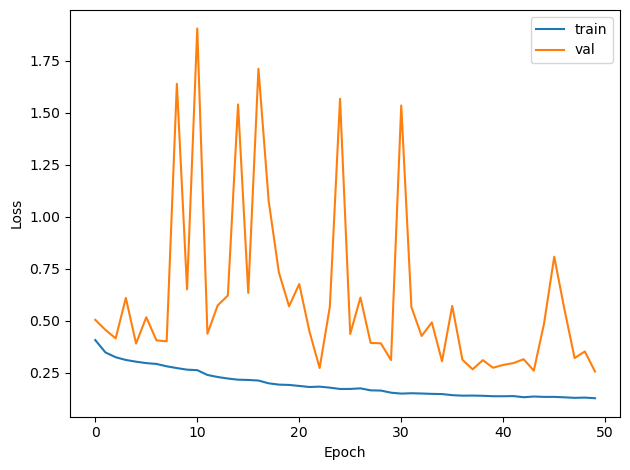

In [87]:
EEG_CNN_SAVE_PATH = CHECKPOINT_ROOT / "eeg_cnn_best_model.pt"
EEG_CNN_SUBMISSION_PATH = SUBMISSION_ROOT / "eeg_cnn_submission.csv"

# train model on training set (or load existing)
train_losses, val_losses = train_model(
        eeg_cnn_model, train_loader, val_loader,
        criterion, optimizer, device,
        save_path=EEG_CNN_SUBMISSION_PATH,
        num_epochs=300,
        patience=30,
        monitor="val_loss",
        scheduler=scheduler,
        overwrite=False,
    )

# plot losses if any
if train_losses:
    plt.figure()
    plt.plot(train_losses, label="train")
    plt.plot(val_losses,   label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [88]:
# evaluate model on test set and generate submission file
evaluate_model(
    eeg_cnn_model, test_loader, device,
    save_path=EEG_CNN_SAVE_PATH,
    submission_path=EEG_CNN_SUBMISSION_PATH
)

Loading model for evaluation from: .checkpoints/eeg_cnn_best_model.pt


KeyError: 'model_state_dict'

### 5. CNN LSTM

In [89]:
%aimport layers.cnn
from layers.cnn import CNN_LSTM

cnn_lstm_model = CNN_LSTM(
    input_channels=19,
    cnn_output_channels=128,
    lstm_hidden_dim=128, 
    fc_dropout=0.3,
    lstm_dropout=0.3,
    num_classes=1,
    bidirectional_lstm=False # unidirectional
)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    cnn_lstm_model = nn.DataParallel(cnn_lstm_model)
cnn_lstm_model = cnn_lstm_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(cnn_lstm_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=5,
    factor=0.5
)

Attempting to load checkpoint from .checkpoints/cnn_lstm_best_model.pt...
Checkpoint found → model loaded, skipping training.


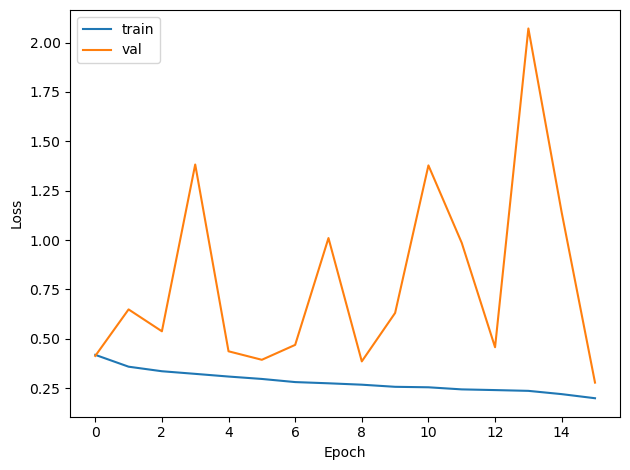

In [90]:
CNN_LSTM_SAVE_PATH = CHECKPOINT_ROOT / "cnn_lstm_best_model.pt"
CNN_LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "cnn_lstm_submission.csv"

# train model on training set (or load existing)
train_losses, val_losses = train_model(
        cnn_lstm_model, train_loader, val_loader,
        criterion, optimizer, device,
        save_path=CNN_LSTM_SAVE_PATH,
        num_epochs=300,
        patience=30,
        monitor="val_loss",
        scheduler=scheduler,
        overwrite=False,
    )

# plot losses if any
if train_losses:
    plt.figure()
    plt.plot(train_losses, label="train")
    plt.plot(val_losses,   label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [91]:
# evaluate model on test set and generate submission file
evaluate_model(
    cnn_lstm_model, test_loader, device,
    save_path=CNN_LSTM_SAVE_PATH,
    submission_path=CNN_LSTM_SUBMISSION_PATH
)

Loading model for evaluation from: .checkpoints/cnn_lstm_best_model.pt


Evaluating: 100%|██████████| 29/29 [00:00<00:00, 192.23it/s]

Saved submission → .submissions/cnn_lstm_submission.csv



/home/ldibello/NeuroGraphNet/util/train.py:264: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  sub_df['id_sort_temp'] = pd.to_numeric(sub_df['id'], errors='ignore')


,id,label
0,pqejgcvm_s001_t000_0,0
1,pqejgcvm_s001_t000_1,0
10,pqejgcvm_s001_t000_10,1
11,pqejgcvm_s001_t000_11,1
12,pqejgcvm_s001_t000_12,1
...,...,...
3551,pqejgvej_s001_t000_95,0
3552,pqejgvej_s001_t000_96,0
3553,pqejgvej_s001_t000_97,0
3554,pqejgvej_s001_t000_98,0


### 6. CNN BiLSTM

In [19]:
%aimport layers.cnn
from layers.cnn import CNN_LSTM

cnn_bi_lstm_model = CNN_LSTM(
    input_channels=19,
    cnn_output_channels=128,
    lstm_hidden_dim=128, 
    fc_dropout=0.3,
    lstm_dropout=0.3,
    num_classes=1,
    bidirectional_lstm=True # unidirectional
)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    cnn_bi_lstm_model = nn.DataParallel(cnn_bi_lstm_model)
cnn_bi_lstm_model = cnn_bi_lstm_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(cnn_bi_lstm_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=5,
    factor=0.5
)

In [20]:
CNN_BI_LSTM_SAVE_PATH = CHECKPOINT_ROOT / "cnn_bi_lstm_best_model.pt"
CNN_BI_LSTM_SUBMISSION_PATH = SUBMISSION_ROOT / "cnn_bi_lstm_submission.csv"

# train model on training set (or load existing)
train_losses, val_losses = train_model(
    cnn_bi_lstm_model, train_loader, val_loader,
    criterion, optimizer, device,
    save_path=CNN_BI_LSTM_SAVE_PATH,
    num_epochs=300,
    patience=30,
    monitor="val_loss",
    scheduler=scheduler,
    overwrite=True,
)

# plot losses if any
if train_losses:
    plt.figure()
    plt.plot(train_losses, label="train")
    plt.plot(val_losses,   label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

Overwrite enabled: Removed existing checkpoint at .checkpoints/cnn_bi_lstm_best_model.pt


Epochs:   0%|                                                                                   | 0/300 [00:00<?, ?it/s]


PicklingError: Can't pickle <function <lambda> at 0x16da8e520>: attribute lookup <lambda> on __main__ failed

In [94]:
# evaluate model on test set and generate submission file
evaluate_model(
    cnn_bi_lstm_model, test_loader, device,
    save_path=CNN_BI_LSTM_SAVE_PATH,
    submission_path=CNN_BI_LSTM_SUBMISSION_PATH
)

Loading model for evaluation from: .checkpoints/cnn_bi_lstm_best_model.pt


Evaluating: 100%|██████████| 29/29 [00:00<00:00, 174.18it/s]

Saved submission → .submissions/cnn_bi_lstm_submission.csv



/home/ldibello/NeuroGraphNet/util/train.py:264: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  sub_df['id_sort_temp'] = pd.to_numeric(sub_df['id'], errors='ignore')


,id,label
0,pqejgcvm_s001_t000_0,0
1,pqejgcvm_s001_t000_1,0
10,pqejgcvm_s001_t000_10,1
11,pqejgcvm_s001_t000_11,1
12,pqejgcvm_s001_t000_12,1
...,...,...
3551,pqejgvej_s001_t000_95,0
3552,pqejgvej_s001_t000_96,0
3553,pqejgvej_s001_t000_97,0
3554,pqejgvej_s001_t000_98,0


## Graph methods

In [ ]:
from util.dataset import GraphEEGDataset

EDGE_STRATEGY = 'spatial' # or 'correlation'
SPATIAL_DISTANCE_FILE = DATA_ROOT / "distances_3d.csv"
CORRELATION_THRESHOLD = 0.7 # If using 'correlation'

# Train EEG Graph dataset
# train_graph_dataset = GraphEEGDataset(
#     root=str(TRAIN_ROOT),
#     metadata_file=str(TRAIN_ROOT / "segments.parquet"),
#     signal_folder=str(TRAIN_ROOT),
#     edge_strategy=EDGE_STRATEGY,
#     spatial_distance_file=str(SPATIAL_DISTANCE_FILE) if EDGE_STRATEGY == 'spatial' else None,
#     correlation_threshold=CORRELATION_THRESHOLD if EDGE_STRATEGY == 'correlation' else 0.7,
#     force_reprocess=False,
#     # target entire signal length
#     target_length=clip_length * sampling_rate,
#     transform=fft_filtering,
# )

In [ ]:
from pathlib import Path
from torch_geometric.data import Data

def train_gcn(
    model: torch.nn.Module,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device: torch.device,
    save_path: Path,
    scheduler=None,
    num_epochs: int = 100,
    patience: int = 10,
):
    """
    Simplified training loop for PyG models with checkpointing,
    LR scheduling, and early stopping based on validation loss.
    Supports loader yielding either PyG Data/Batch or tuples of tensors
    (x, edge_index, batch_idx, y).
    """
    best_val_loss = float('inf')
    early_stop_counter = 0
    train_hist, val_hist = [], []

    for epoch in range(1, num_epochs + 1):
        # --- Training Phase -------------------------------------------------
        model.train()
        train_loss = 0.0
        total_graphs = 0
        for batch in train_loader:
            # Handle different batch types
            if hasattr(batch, 'to'):
                # if PyG Batch, moves to device directly
                data = batch.to(device)
            else:
                print(len(batch))
                # Expect tuple (x, edge_index, batch_idx, y)
                x, edge_index, batch_idx, y = batch
                
                # load each tensor to device
                x = x.to(device)
                edge_index = edge_index.to(device)
                batch_idx = batch_idx.to(device)
                y = y.to(device)

                # merge everything into a Data object
                data = Data(x=x, edge_index=edge_index, batch=batch_idx, y=y)

            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

            # Accumulate loss
            n = getattr(data, 'num_graphs', 1)
            train_loss += loss.item() * n
            total_graphs += n

        avg_train_loss = train_loss / total_graphs
        train_hist.append(avg_train_loss)

        # --- Validation Phase -----------------------------------------------
        model.eval()
        val_loss = 0.0
        total_graphs = 0
        with torch.no_grad():
            for batch in val_loader:
                if hasattr(batch, 'to'):
                    data = batch.to(device)
                else:
                    x, edge_index, batch_idx, y = batch
                    x = x.to(device)
                    edge_index = edge_index.to(device)
                    batch_idx = batch_idx.to(device)
                    y = y.to(device)
                    data = Data(x=x, edge_index=edge_index, batch=batch_idx, y=y)

                out = model(data.x, data.edge_index, data.batch)
                loss = criterion(out, data.y)

                n = getattr(data, 'num_graphs', 1)
                val_loss += loss.item() * n
                total_graphs += n

        avg_val_loss = val_loss / total_graphs
        val_hist.append(avg_val_loss)

        # --- Scheduler ------------------------------------------------------
        if scheduler is not None:
            # if ReduceLROnPlateau, pass validation loss
            if hasattr(scheduler, 'step') and scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                scheduler.step(avg_val_loss)
            else:
                scheduler.step()

        # --- Logging --------------------------------------------------------
        print(f"Epoch {epoch:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # --- Early Stopping & Checkpointing --------------------------------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
            # Save state_dict of unwrapped model
            torch.save(getattr(model, 'module', model).state_dict(), save_path)
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    # Load best model weights
    model.load_state_dict(torch.load(save_path, map_location=device))
    return train_hist, val_hist

In [ ]:
from layers.eeggcn import EEGGCN

# Get number of time points (in_channels) from first sample
cnn_lstm_model = EEGGCN(
    in_channels=19,
    hidden_channels=128,
    out_channels=32,
    num_classes=2,
    num_conv_layers=3,
    dropout=0.5
)
if torch.cuda.device_count() > 1:
    cnn_lstm_model = nn.DataParallel(cnn_lstm_model)
cnn_lstm_model = cnn_lstm_model.to(device)

# Set up optimizer + scheduler
optimizer = optim.Adam(cnn_lstm_model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)
criterion = nn.BCEWithLogitsLoss()

EEGGCN_SAVE_PATH = CHECKPOINT_ROOT / "eeggcn_best_model.pt"
EEGCN_SUBMISSION_PATH = SUBMISSION_ROOT / "eeggcn_submission.csv"

# train model on training set (or load existing)
train_hist, val_hist = train_gcn(
    cnn_lstm_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    save_path   = Path("eegcnn_attn.pt"),
    scheduler   = scheduler,
    num_epochs  = 250,
    patience    = 15,
)

_ = evaluate_model(
    cnn_lstm_model, test_loader, device,
    save_path       = Path("eeggcn_attn.pt"),
    submission_path = Path("eeggcn_submission.csv"),
    threshold       = 0.5,
)